# MP1: Marching Squares

In this activity, you will implement marching squares to draw 2D contour lines. The algorithm is described in
in the Week 3 Lesson enititled Contouring: Marching Squares. You can also refer to the
Wikipedia article (http://en.wikipedia.org/wiki/Marching_squares).

You will also implement and apply a new colormap and interpolation function. 

By the end of this activity, you should be able to generate an interactive visualization that toggles between the presence of contour lines, the colormap, and the use of interpolation on your contour lines. Your visualization should be able to produce the following images:

<table>
    <tr>
        <td><h3 align="center">Grayscale</h3><img src='grayscale-rough.png' width='300'/></td>
        <td><h3 align="center">Plasma</h3><img src='plasma-rough.png' width='300'/></td>
        <td><h3 align="center">Plasma with Interpolation</h3><img src='plasma-interpolated.png' width='300'/></td>   
    </tr>
</table>

To simplify the assignment, we have taken care of the plotting required to create the visualization. You are only responsible for implementing the placeholder functions that are defined in Parts 1, 2, 3, and 4.

Let's start by importing the libraries that we will use in this activity.

In [1]:
import random
import pylab as plt
import numpy as np

In [2]:
from matplotlib.widgets import Button
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib notebook

We will use a 2-D Gaussian function to generate the grid that we will apply marching squares to.

In [3]:
def gauss_2d(mu, sigma, size=10):
  x, y = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
  d    = np.sqrt(x*x+y*y)
  g    = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  return g

The following code constructs the `March` class which uses the functions you will define later on to plot an interactive visualization. This class uses the `matplotlib` library to generate the grid, contour lines, and colormaps.

**Do NOT edit this class.** You may read through it for your own edification to understand how the visualization is constructed, but it is not necessary to implement the other functions.

In [4]:
class March(object):
    def __init__(self,res=32,thres=0.5,size=320):

        #Initialize variables
        self.res      = res                      #Number of grid cells per axis
        self.thres    = thres                    #Threshold for binarization
        self.size     = size                     #Size of image (in pixels)
        self.contours = 0                        #Whether we're showing contours (0 = off,  1 = normal, 2 = interpolated)
        self.cmap     = self.colorMapGrayscale() #Default grayscale color map
        self.cmapi    = 0                        #Index of color map (0 = gray, 1 = plasma, 2 = custom)

        #Hardcode some cells to start with to test all cases
        self.cells    = gauss_2d(0.5,0.4,self.res)

        #Compute other useful variables from grid size
        self.step     = self.size // self.res #Spacing between grid lines (in pixels)

        #Set up axes
        self.fig, self.axes = plt.subplots()
        self.axes.set_aspect('equal')
        plt.subplots_adjust(bottom=0.2)

        #Set up buttons
        self.btog = Button(plt.axes([0.61, 0.05, 0.2, 0.075]), 'No Contours')
        self.btog.on_clicked(self.toggle_contours)
        self.bmap = Button(plt.axes([0.41, 0.05, 0.2, 0.075]), 'Grayscale')
        self.bmap.on_clicked(self.toggle_colormap)

        #Perform initial drawing
        self.redraw()

    def show(self):
        plt.show()

    def update(self):
        self.fig.canvas.draw()

    def toggle_contours(self,event):
        #Toggle whether we draw contours or not
        self.contours = (self.contours + 1) % 3
        self.redraw()

    def toggle_colormap(self,event):
        self.cmapi = (self.cmapi+1)%2
        if self.cmapi == 0:
          self.cmap = self.colorMapGrayscale()
          self.bmap.label.set_text("Grayscale")
        elif self.cmapi == 1:
          self.cmap = colorMapPlasma()
          self.bmap.label.set_text("Plasma")
        self.redraw()

    def redraw(self):
        # Regenerate a blank white canvas withou axis lines or tick marks
        self.axes.clear()
        self.axes.set_yticks([])
        self.axes.set_xticks([])
        self.axes.set_yticklabels([])
        self.axes.set_xticklabels([])

        #Invert y axis to match up with array ordering
        self.axes.invert_yaxis()

        #Draw the image from our img matrix
        self.drawImage()
        if self.contours == 0:
          for i in range(1,self.res): #Draw image grid
            self.axes.plot([0,self.size-1], [self.step*i,self.step*i], color='black', linestyle='-', linewidth=1)
            self.axes.plot([self.step*i,self.step*i], [0,self.size-1], color='black', linestyle='-', linewidth=1)
          self.btog.label.set_text('No Contours')
        else:  # Draw contours and contour grid
          for i in range(self.res): #Draw contour grid
            self.axes.plot([0,self.size-1], [self.step*(i+0.5),self.step*(i+0.5)], color='gray', linestyle='-', linewidth=1)
            self.axes.plot([self.step*(i+0.5),self.step*(i+0.5)], [0,self.size-1], color='gray', linestyle='-', linewidth=1)
          if self.contours == 1:
            self.btog.label.set_text('Rough Contours')
            self.drawTableLookupContours()
          else:
            self.btog.label.set_text('Interp. Contours')
            self.drawInterpolatedContours()

        #Update the underlying plot
        self.update()

    def colorMapGrayscale(self):
        cdict = {'red':   [[0, 0, 0],
                           [1, 1, 1]],
                 'green': [[0, 0, 0],
                           [1, 1, 1]],
                 'blue':  [[0, 0, 0],
                           [1, 1, 1]]}
        return cdict

    def drawImage(self):
        newcmp = LinearSegmentedColormap('testCmap', segmentdata=self.cmap, N=256)
        self.axes.imshow(gauss_2d(0.5,0.4,self.size),cmap=newcmp)

    def drawTableLookupContours(self):
        for y,row in enumerate(self.cells):
          for x,cell in enumerate(row):
            case = getContourCase(y,x,self.thres,self.cells)
            self.drawCellContourByCase(y,x,case)

    def drawInterpolatedContours(self):
        segments = getContourSegments(self.thres,self.cells)
        for s in segments:
          x1 = self.step*(0.5+s[0][0])
          x2 = self.step*(0.5+s[1][0])
          y1 = self.step*(0.5+s[0][1])
          y2 = self.step*(0.5+s[1][1])
          self.axes.plot([x1,x2], [y1,y2], color='green', linestyle='-', linewidth=1)

    def drawCellContourByCase(self,yrow,xcol,case):
        if case in [0,15]:
          return #Nothing to draw for empty cells, completely surrounded cells, or border cells

        #Handle saddle points
        if case in [5]:
          if disambiguateSaddle(yrow,xcol,self.thres,self.cells):
            self.drawCellContourByCase(yrow,xcol,2)
            self.drawCellContourByCase(yrow,xcol,7)
          else:
            self.drawCellContourByCase(yrow,xcol,11)
            self.drawCellContourByCase(yrow,xcol,14)
          return
        if case in [10]:
          if disambiguateSaddle(yrow,xcol,self.thres,self.cells):
            self.drawCellContourByCase(yrow,xcol,11)
            self.drawCellContourByCase(yrow,xcol,14)
          else:
            self.drawCellContourByCase(yrow,xcol,2)
            self.drawCellContourByCase(yrow,xcol,7)
          return

        #Compute coordinates based on case lookup table
        s    = self.step
        ymin = s*yrow + (0         if case in [4,6,7,8,9,11]   else s//2)
        ymax = s*yrow + (self.step if case in [1,2,6,9,13,14]  else s//2)
        xmin = s*xcol + (0         if case in [1,3,7,8,12,14]  else s//2)
        xmax = s*xcol + (self.step if case in [2,3,4,11,12,13] else s//2)
        if case in [2,7,8,13]: #Reverse direction for lines drawn up and right (i.e., x increases while y decreases)
          xmin,xmax = xmax,xmin

        #Contour lines should be drawn halfway between grid cells, so set an offset
        off = s//2
        #Smooth contours should have different color
        color = 'red' if self.contours == 1 else 'green'
        #Actually draw the contour lines
        self.axes.plot([xmin+off, xmax+off], [ymin+off, ymax+off], color=color, linestyle='-', linewidth=1)
        return

## Part 1: Getting the Contour Case

The basic idea of marching squares is to "march" from one cell to another and classify each cell into a specific contour case, using the values at the corners of the cell. 

These contour cases will be located in a lookup table consisting of 16 entries. Each entry represents a different contour case (the edges that the contour line intersects) and maps to a unique index. 

We have already implemented the lookup table in the `March` class, but you will need to build the index for the contouring cells. You can refer to https://en.wikipedia.org/wiki/Marching_squares for how to build a binary index.

Define the function `getContourCase()` to determine the contour lookup table index for a contouring cell corresponding to a 2x2 block of grid cells specified by `cells`.

The parameters of the function are:
- `top`: the y-index of the top-left grid cell relative to the contouring cell
- `left`: the x-index of the top-left grid cell relative to the contouring cell
- `thres`: the threshold/isovalue 
- `cells`: a 2-D array of grid cells/values

This function should return an integer between `0` and `15` inclusive indicating the contouring cell's index in the contouring lookup table. Your function should return `0` any time an out-of-bounds access is encountered. You should not assume the size of the 2D array passed in the `cells` parameter, so your function should handle the general out of bounds case gracefully.

Note that grid cells are distinct from contouring cells. Contouring cells are denoted using the four surrounding grid cells and they share their index with the top-left grid cell. For example, the contouring cell at (0,2) as denoted by the parameters `top=0, left=2` uses the Gaussian `cells` at (0,2), (1,2), (0,3), and (1,3).  Equivalently, you can think about the 2D array of grid `cells` as a 2D array of vertices for the contouring cells.

In [5]:
def getContourCase(top,left,thres,cells):
    # YOUR CODE HERE
#     raise NotImplementedError

    # Check if top or left is out of bounds
    cells_shape = cells.shape
    if top not in range(cells_shape[0] - 1) or left not in range(cells_shape[1] - 1):
        return 0
    
    # Read value in CW fashion and generate the case binary
    clockwise = [[0,0],[0,1],[1,1],[1,0]]
    case_binary = ''
    for e in clockwise:
        if cells[top + e[0]][left + e[1]] >= thres:
            case_binary += '1'
        else:
            case_binary += '0'
#     print(case_binary)
    
    # Convert case binary to 0 - 15
    case_num = 0
    for index, bit in enumerate(reversed(case_binary)):
        case_num += int(bit) * (2**index)
    
    return case_num

In [6]:
## Tests for getContourCase() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

test_cases = np.array([[0.5,0.6,0.6,0.5],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4]])
assert getContourCase(0,0,0.5,test_cases) == 15
assert getContourCase(0,2,0.5,test_cases) == 13
assert getContourCase(2,2,0.5,test_cases) == 9

## Part 2: Disambiguating Saddle Points

There are some cases, called saddle points, where the contour is ambiguous. In other words, there are multiple edges that can serve as a valid contour for that case. To resolve the ambiguous cases, you should average the function values at the corners of the contouring cell to generate a sample in the square center. For further information, see <https://en.wikipedia.org/wiki/Marching_squares#Disambiguation_of_saddle_points>.

Define the Boolean function `disambiguateSaddle()` to determine the orientation of line segments in a contouring cell with ambiguous values in the surrounding 2x2 block of grid cells.

The parameters of the function are:
- `top`: the y-index of the top-left grid cell relative to the contouring cell
- `left`: the x-index of the top-left grid cell relative to the contouring cell
- `thres`: the threshold/isovalue 
- `cells`: a 2-D array of grid cells/values

This function should return `True` if the averaged sample cell is greater than or equal to the threshold, and `False` otherwise.

In [7]:
def disambiguateSaddle(top,left,thres,cells):
    # YOUR CODE HERE
#     raise NotImplementedError
    # Read value in CW fashion and generate the case binary
    clockwise = [[0,0],[0,1],[1,1],[1,0]]
    corner_sum = 0.0
    
    for e in clockwise:
        corner_sum += cells[top + e[0]][left + e[1]]
    
    if corner_sum / 4 >= thres:
        return True
    else:
        return False
    
    

In [8]:
### Tests for disambiguateSaddle() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

test_cases = np.array([[0.5,0.6,0.6,0.5],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4]])
assert disambiguateSaddle(0,1,0.5,test_cases) == True
assert disambiguateSaddle(0,1,0.6,test_cases) == True
assert disambiguateSaddle(0,1,0.7,test_cases) == False
assert disambiguateSaddle(1,2,0.5,test_cases) == True
assert disambiguateSaddle(1,2,0.6,test_cases) == False
assert disambiguateSaddle(1,2,0.7,test_cases) == False

## Part 3: Interpolating the Contour Lines

Only using `getContourCase()` will default to intersecting the contour lines at the midpoints of each edge, resulting in "rough" contours. To smoothen the contours, we will use linear interpolation to find the exact position of the contour line along the edges of the cell.

First, define the function `interpolate()` to determine the relative position of a value `t` between two values `v1` and `v2`.

The parameters of the function are:
- `v1`: the first value to use for linear interpolation
- `v2`: the second value to use for linear interpolation
- `t`: the number for which to find the relative position between `v1` and `v2`.

This function should return a float between 0 and 1 designating the relative position of `t` between `v1` and `v2`.

In [9]:
def interpolate(v1,v2,t):
    # YOUR CODE HERE
#     raise NotImplementedError
    return (t - v1) / (v2 - v1)
    

In [10]:
### Tests for interpolate() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

assert interpolate(1.5,2.5,2.5) ==  1/1
assert interpolate(1.5,2.5,2)   ==  1/2
assert interpolate(1.5,2.5,1.5) ==  0/1
assert interpolate(1,4,2)       ==  1/3


Now that we have defined our interpolation function, we can use it to obtain the exact coordinates of a contour line's endpoints.

Define the function `getCellSegments()` to produce a list of line segments representing contour lines within a given contouring cell.

The parameters of the function are:
- `top`: the y-index of the top-left grid cell relative to the contouring cell
- `left`: the x-index of the top-left grid cell relative to the contouring cell
- `thres`: the threshold/isovalue 
- `cells`: a 2-D array of grid cells/values

This function should return a list of pairs of (x, y) coordinates indicating contour segments within a cell e.g. [ [(x1,y1),(x2,y2)], [(x3,y3),(x4,y4)] ]. If any of the grid cells bordering a countouring cell are out of bounds, your function should just return an empty list `[]`.

**Notes**: 
- Coordinates assume an origin of (0,0) in the top left of the grid. 
- Coordinates should be computed in terms of grid cell lengths, not pixel coordinates, e.g., the coordinate (5 ,7.5) indicates 5 grid cells right and 7.5 grid cells down from the origin.
- For contouring cells four intersection points, you will need use the `disambiguateSaddle()` function to determine which two pairs of points form the contouring lines for the cell, and may need to reorder the pairs of points in your returned list accordingly.

In [11]:
def getCellSegments(top,left,thres,cells):
    # YOUR CODE HERE
#     raise NotImplementedError

    case_num = getContourCase(top,left,thres,cells)
    
    # Return empty list on case 0 or 15
    if case_num in [0, 15]:
        return []
    
    inter_top = interpolate(cells[top][left], cells[top][left + 1],thres)
    inter_left = interpolate(cells[top][left], cells[top + 1][left],thres)
    inter_bottom = interpolate(cells[top + 1][left], cells[top + 1][left + 1],thres)
    inter_right = interpolate(cells[top][left + 1], cells[top + 1][left + 1],thres)

    top_point = (top, left + inter_top)
    left_point = (top + inter_left, left)
    bottom_point = (top + 1, left + inter_bottom)
    right_point = (top + inter_right, left + 1)
    
    # 1 line segment
    if case_num not in [5, 10]:
        # print(f'1 line segment case: {case_num}')
        
        if case_num == 1:
            return [[left_point, bottom_point]]
        elif case_num == 2:
            return [[bottom_point, right_point]]
        elif case_num == 3:
            return [[left_point, right_point]]
        elif case_num == 4:
            return [[top_point, right_point]]
        elif case_num == 6:
            return [[top_point, bottom_point]]
        elif case_num == 7:
            return [[left_point, top_point]]
        elif case_num == 8:
            return [[left_point, top_point]]
        elif case_num == 9:
            return [[top_point, bottom_point]]
        elif case_num == 11:
            return [[top_point, right_point]]
        elif case_num == 12:
            return [[left_point, right_point]]
        elif case_num == 13:
            return [[bottom_point, right_point]]
        elif case_num == 14:
            return [[left_point, bottom_point]]
            
    # 2 line segment
    else:
        # For case 5 and 10
        # print(f'2 line segment case: {case_num}')
        
        saddle = disambiguateSaddle(top,left,thres,cells)
        
        if (case_num == 5 and saddle) or (case == 10 and not saddle):
            return [[left_point, top_point],[bottom_point, right_point]]
        else:
            return [[left_point, bottom_point],[top_point, right_point]]
    
    

In [12]:
### Tests for getCellSegments() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

test_cases_1 = np.array([[0.5,0.6,0.6,0.5],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4],[0.5,0.7,0.7,0.4]])
assert getCellSegments(3,3,0.9,test_cases_1) == []

test_cases_2 = np.array([[0.07339991, 0.38311005, 0.38311005, 0.07339991],[0.38311005, 0.99744795, 0.99744795, 0.38311005],[0.38311005, 0.99744795, 0.99744795, 0.38311005],[0.07339991, 0.38311005, 0.38311005, 0.07339991]])
result = getCellSegments(0,0,0.2,test_cases_2)
result[0].sort()
try:
    np.testing.assert_allclose(result, [[(0, 0.40876959985875827), (0.40876959985875827, 0)]], rtol=1e-5)
except:
    np.testing.assert_allclose(result, [[(0.40876959985875827, 0), (0, 0.40876959985875827)]], rtol=1e-5)


test_cases_3 = np.array([[0.05,0.4,0.4,0.05],[0.4,0.9,0.9,0.4],[0.4,0.9,0.9,0.4],[0.05,0.4,0.4,0.05]])
result = getCellSegments(2,2,0.2,test_cases_3)
result[0].sort()
try:
    np.testing.assert_allclose(result, [[(2.571428571428571, 3), (3, 2.571428571428571)]], rtol=1e-5)
except:
    np.testing.assert_allclose(result, [[(3, 2.571428571428571), (2.571428571428571, 3)]], rtol=1e-5)
    

We can now apply the above function to all of the contouring cells in our grid.

Define the function `getContourSegments()` to produce a list of pairs of coordinates, where each pair of coordinates represents a line segment used for drawing the contours of a Marching Squares invocation.

The parameters of the function are:
- `thres`: the threshold/isovalue 
- `cells`: a 2-D array of grid cells/values

This function should return a list of pairs of (x, y) coordinates indicating all contour segments for the grid e.g. [ [(x1,y1),(x2,y2)], [(x3,y3),(x4,y4)] ].

**Note:** In the test cases, we will round your results to three decimal places. Do NOT implement any rounding within your functions.

In [13]:
def getContourSegments(thres,cells):
    #Hint: this function should accumulate a list of line segments by looping
    #      over each cell in "cells" and calling getCellSegments() on each cell
    # YOUR CODE HERE
    #raise NotImplementedError
    line_segments = []
    
    cells_shape = cells.shape

    for top in range(cells_shape[0] - 1):
        for left in range(cells_shape[1] - 1):
            line_segments.extend(getCellSegments(top,left,thres,cells))
    
    #print(line_segments)
    return line_segments
    

In [14]:
### Tests for getContourSegments() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

test_cases = np.array([[0.07339991, 0.38311005, 0.38311005, 0.07339991],[0.38311005, 0.99744795, 0.99744795, 0.38311005],[0.38311005, 0.99744795, 0.99744795, 0.38311005],[0.07339991, 0.38311005, 0.38311005, 0.07339991]])
result = getContourSegments(0.9,test_cases)

rounded_result = []
for [(x1, y1), (x2, y2)] in result:
    rounded_result.append([(round(x1, 3),round(y1, 3)),(round(x2, 3),round(y2, 3))])

answer = [[(0.841, 1), (0.841, 2)], [(0.841, 1), (1, 0.841)], [(0.841, 2), (1, 2.159)], [(1, 0.841), (2, 0.841)], [(1, 2.159), (2, 2.159)], [(2, 0.841), (2.159, 1)], [(2.159, 1), (2.159, 2)], [(2, 2.159), (2.159, 2)]]

for [(x1,y1),(x2,y2)] in rounded_result:
    assert [(x1,y1),(x2,y2)] in answer or  [(x2,y2),(x1,y1)] in answer

for [(x1,y1),(x2,y2)] in answer:
    assert [(x1,y1),(x2,y2)] in rounded_result or  [(x2,y2),(x1,y1)] in rounded_result


## Part 4: Creating a Colormap

In addition to rendering the contour lines, your code should display the function across the domain using the Plasma color map.

Define the function `colorMapPlasma()` to create a Plasma color map for mapping scalar data to colors. 

The function should return a dictionary containing a Plasma color map usable by matplotlib's `LinearSegmentedColormap()` function. 

You should refer to documentation on LinearSegmentedColormap (https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html) and on the Plasma color map (https://www.kennethmoreland.com/color-advice/). Use the byte representation of the color table with 8 anchor values.

**Note:** For this function, do NOT round any values. You should use the full precision provided in the color table. You may need to click on each scalar value in the table to see the value with higher precision.

In [15]:
def colorMapPlasma():
    # YOUR CODE HERE
    # raise NotImplementedError
    return {'red':   [(0.0,  13/255, 13/255),
                       (0.142857142857142,  84/255, 84/255),
                       (0.285714285714285,  139/255, 139/255),
                       (0.428571428571428,  185/255, 185/255),
                       (0.571428571428571,  219/255, 219/255),
                       (0.714285714285714,  244/255, 244/255),
                       (0.857142857142857,  254/255, 254/255),
                       (1.0,  240/255, 240/255)],

             'green': [(0.0,  8/255, 8/255),
                       (0.142857142857142,  2/255, 2/255),
                       (0.285714285714285,  10/255, 10/255),
                       (0.428571428571428,  50/255, 50/255),
                       (0.571428571428571,  92/255, 92/255),
                       (0.714285714285714,  136/255, 136/255),
                       (0.857142857142857,  188/255, 188/255),
                       (1.0,  249/255, 249/255)],

             'blue':  [(0.0,  135/255, 135/255),
                       (0.142857142857142,  163/255, 163/255),
                       (0.285714285714285,  165/255, 165/255),
                       (0.428571428571428,  137/255, 137/255),
                       (0.571428571428571,  104/255, 104/255),
                       (0.714285714285714,  73/255, 73/255),
                       (0.857142857142857,  43/255, 43/255),
                       (1.0,  33/255, 33/255)]}
    

In [16]:
### Tests for colorMapPlasma() function. 
### Please DO NOT hard-code the answers as we will also be using hidden test cases when grading your submission.

test_dict = colorMapPlasma()
np.testing.assert_allclose(test_dict['red'][1], [0.142857142857142, 84/255, 84/255], rtol=1e-5)
np.testing.assert_allclose(test_dict['green'][3], [0.428571428571428,  50/255,  50/255], rtol=1e-5)

Now we can finally generate our 2-D interactive visualization! If your functions were defined correctly, you should be able to toggle the visualization to see the images from the beginning of this notebook.

<IPython.core.display.Javascript object>


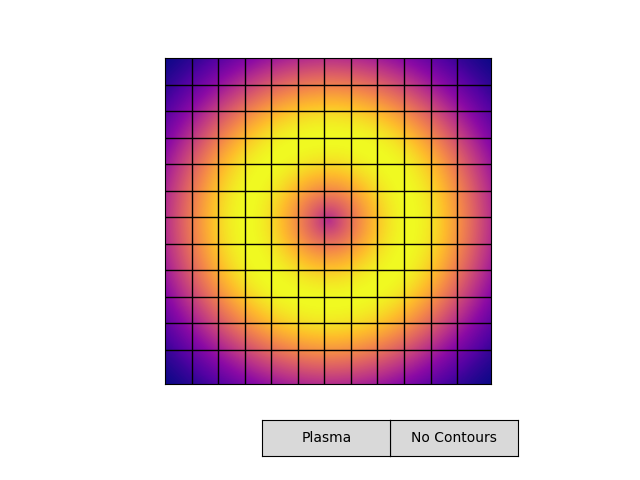

In [17]:
March(res=12,thres=0.9).show()